In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

imputed_data = pd.read_csv("sbux_clv_drop_AOV_and_completed_offers_across_channels_with_dummies.csv")

# Prepare the data
X = imputed_data[['MemberSince',
       'Recency (# Days ago from last trans. As of final day up to Day 15)',
       'Frequency (# Trans. from Day 1-15)',
       'Monetary Value (Sum of Trans. from Day 1-15)',
       '# of Marketing offers that Starbucks sent to each customer from Day 1-15',
       '# of Marketing offers that were viewed from Day 1-15',
       '# of Marketing offers that were successfully completed from Day 1-15',
       'Marketing Offer View Rate from Day 1-15',
       'Marketing Offer Response Rate from Day 1-15',
       'Age_18-34', 'Age_35-50', 'Age_51-67',
       'Age_68-84', 'Age_85-101', 'Gender_F', 'Gender_M',#'Age_Unknown',
       'Gender_O', 'HH Income_100k-120k',#'Gender_Unknown','HH Income_Unknown'
       'HH Income_30k-50k', 'HH Income_50k-75k', 'HH Income_75k-100k']]

y = imputed_data['Sum(Trans. Amt from Day 16-30)']

# Define the models
mlr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
svr = SVR()
lgbm = LGBMRegressor()
mlp = MLPRegressor()
kr = KernelRidge()

# Define base estimators to be used in the ensemble
base_estimators = [('rf', RandomForestRegressor()),
                   ('xgb', XGBRegressor()),
                   ('dt', DecisionTreeRegressor())]

# Define a final estimator to combine the predictions of the base estimators
final_estimator = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                 ('lasso', LassoCV())])

# Define a StackingRegressor object with the base and final estimator
stacked = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True)

# Fit and evaluate each model using cross-validation
models = {'MLR': mlr, 'Ridge': ridge, 'Lasso': lasso, 'Elastic Net': elastic, 'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb, 'SVR': svr, 'Stacked Ensemble': stacked, 'LGBM':lgbm, 'MLP':mlp, 'Kernel Ridge': kr, 'KNN': KNeighborsRegressor()}
# Define an empty list to store the R-squared values for each model
r2_values_train = []
r2_values_test = []

metrics_dict = {}
for name, model in tqdm(models.items(), desc="Processing models"):
    metrics_dict[name] = []
    
    # Evaluate the model using cross-validation on the training set
    mae_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    mape_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error')
    r2_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').flatten()  # use flatten() here
    
    # Evaluate the model on the test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    r2_test = r2_score(y_test, y_pred_test)
    
    metrics_dict[name].extend([mae_train.mean(), mape_train.mean(), r2_train.mean(), mae_test, mape_test, r2_test])
    r2_values_train.append(r2_train.flatten())  # use flatten() here
    r2_values_test.append(r2_test)

# Create a DataFrame and print the results
metrics_df = pd.DataFrame(metrics_dict, index=['MAE Train', 'MAPE Train', 'R^2 Train', 'MAE Test', 'MAPE Test', 'R^2 Test']).T
metrics_df.index.name = 'Model'
print(metrics_df.to_string())

Processing models: 100%|███████████████████████████████████████████████████████████████████████████| 13/13 [49:31<00:00, 228.57s/it]

                  MAE Train    MAPE Train  R^2 Train   MAE Test  MAPE Test  R^2 Test
Model                                                                               
MLR               40.227077  3.964914e+15   0.163568  38.787587        inf  0.178698
Ridge             40.271006  3.954799e+15   0.165642  38.785794        inf  0.178690
Lasso             40.992802  3.935513e+15   0.155344  39.437502        inf  0.170399
Elastic Net       43.099674  3.860506e+15   0.124916  41.613133        inf  0.136458
Decision Tree     56.159303  3.034482e+15  -0.847371  51.717232        inf -0.784129
Random Forest     40.608947  3.729221e+15   0.122530  38.955720        inf  0.145472
XGBoost           40.700650  3.324480e+15   0.052611  38.952030        inf  0.083399
SVR               46.035803  2.490902e+15  -0.044348  44.160211        inf -0.037977
Stacked Ensemble  39.555828  3.755348e+15   0.156697  38.158397        inf  0.195693
LGBM              37.637109  3.515628e+15   0.167404  35.686080  

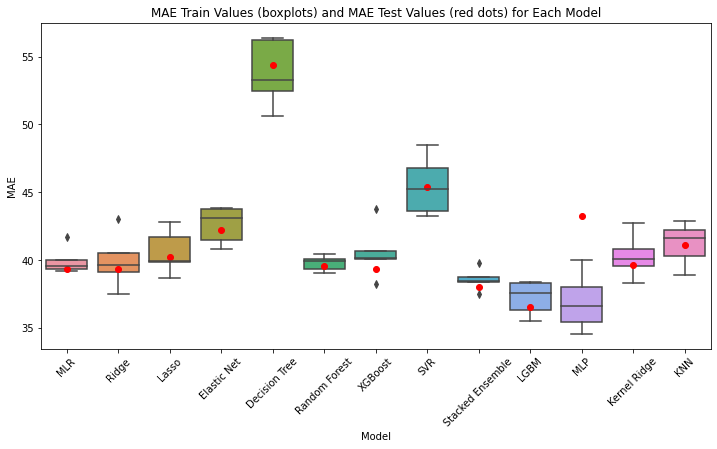

In [36]:
import seaborn as sns

# Prepare lists to store model names and MAE values
mae_train_values = []
mae_test_values = []
model_names = []

# Fill the lists with values
for name, model in models.items():
    model_names.append(name)
    mae_train_values.append(metrics_dict[name][0])  # Assuming MAE Train values are stored here
    mae_test_values.append(metrics_dict[name][3])  # Assuming MAE Test value is stored here

# Create a DataFrame
df = pd.DataFrame(data=mae_train_values, index=model_names, columns=[f'Fold {i+1}' for i in range(len(mae_train_values[0]))])

# Melt the DataFrame to a long format for Seaborn
df_melt = df.reset_index().melt(id_vars='index')

# Create a boxplot to visualize the MAE Train values for each model
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melt, x='index', y='value')

# Add a red dot to represent the MAE Test value for each model
for i, model in enumerate(model_names):
    plt.plot(i, mae_test_values[i], 'ro')

# Set labels and title
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE Train Values (boxplots) and MAE Test Values (red dots) for Each Model')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

plt.show()


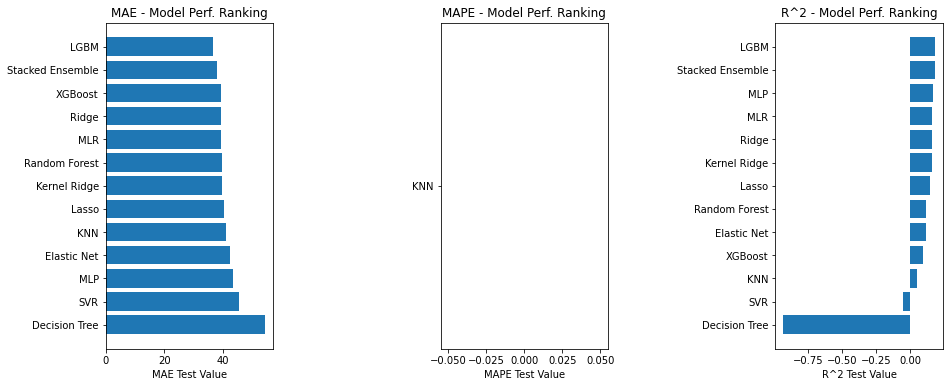

In [40]:
# Extract the metrics for each model
mae_values = metrics_df['MAE Test'].values
mape_values = metrics_df['MAPE Test'].values
r2_values = metrics_df['R^2 Test'].values
labels = metrics_df.index.values

# Sort the metrics in the desired order
mae_idx = mae_values.argsort()[::-1]
mape_idx = mape_values.argsort()[::-1]
r2_idx = r2_values.argsort()

# Set up the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Create bar charts for each metric
axs[0].barh(labels[mae_idx], mae_values[mae_idx])
axs[0].set_title('MAE - Model Perf. Ranking')
axs[0].set_xlabel('MAE Test Value')
axs[1].barh(labels[mape_idx], mape_values[mape_idx])
axs[1].set_title('MAPE - Model Perf. Ranking')
axs[1].set_xlabel('MAPE Test Value')
axs[2].barh(labels[r2_idx], r2_values[r2_idx])
axs[2].set_title('R^2 - Model Perf. Ranking')
axs[2].set_xlabel('R^2 Test Value')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=1)

# Show the plot
plt.show()